In [14]:
from pyprojroot import here

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as vis_transforms

import searchnets
from searchnets import transforms
from searchnets.datasets import VOCDetection

In [2]:
VSD_DATASET_SPLIT_CSV = here().joinpath('data/Visual_Search_Difficulty_v1.0/VSD_dataset_split.csv')

VSD_FOR_VISUALIZE_CSV = here().joinpath('data/Visual_Search_Difficulty_v1.0/VSD_dataset_for_visualizing.csv')

re-make csv used just to visualize dataset.

In [3]:
remake_csv_for_visualize = False

if remake_csv_for_visualize:
    vsd_df = pd.read_csv(VSD_DATASET_SPLIT_CSV)
    vsd_df['split'] = 'train'  # set 'split' to 'train' for all rows so we can get all of dataset from one dataloader
    vsd_df = vsd_df.sort_values(by='difficulty_score')

    vsd_df.to_csv(VSD_FOR_VISUALIZE_CSV)

else:
    vsd_df = pd.read_csv(VSD_FOR_VISUALIZE_CSV)

In [12]:
ROOT = '/home/bart/Documents/data/voc/'
PAD_SIZE = searchnets.transforms.functional.VSD_PAD_SIZE

transform = vis_transforms.Compose(
    [vis_transforms.ToTensor(),
     transforms.RandomPad(pad_size=PAD_SIZE),
     ]
)


target_transform = vis_transforms.Compose([
    transforms.ParseVocXml(),
    transforms.ClassIntsFromXml(),
    transforms.OneHotFromClassInts(),
])

trainset = VOCDetection(root=ROOT,
                        csv_file=VSD_FOR_VISUALIZE_CSV,
                        image_set='trainval',
                        split='train',
                        download=True,
                        transform=transform,
                        target_transform=target_transform
                        )

BATCH_SIZE = 64
NUM_WORKERS = 32

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=NUM_WORKERS,
                          pin_memory=True)

Using downloaded and verified file: /home/bart/Documents/data/voc/VOCtrainval_11-May-2012.tar


In [15]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [26]:
n_samples = len(vsd_df)
ind_25_pct = int(n_samples * 0.25)
ind_75_pct = int(n_samples * 0.75)

IMGS_TO_USE_FOR_VIS = [
    vsd_df['img'].values[0],
    vsd_df['img'].values[ind_25_pct],
    vsd_df['img'].values[ind_75_pct],
    vsd_df['img'].values[-1],
]

In [28]:
batch = next(iter(train_loader))

In [36]:
batch.keys()

dict_keys(['img', 'name', 'target', 'largest', 'random', 'index', 'vsd_score'])

In [46]:
KEYS = ['img', 'name', 'vsd_score']

FOR_FIG = {}

for batch in train_loader:
    for ind, name in enumerate(batch['name']):
        if name in IMGS_TO_USE_FOR_VIS:
            FOR_FIG[name] = {
                'img': batch['img'][ind].cpu().numpy(),
                'vsd_score': batch['vsd_score'][ind].cpu().numpy(),
            }

In [71]:
sns.set()

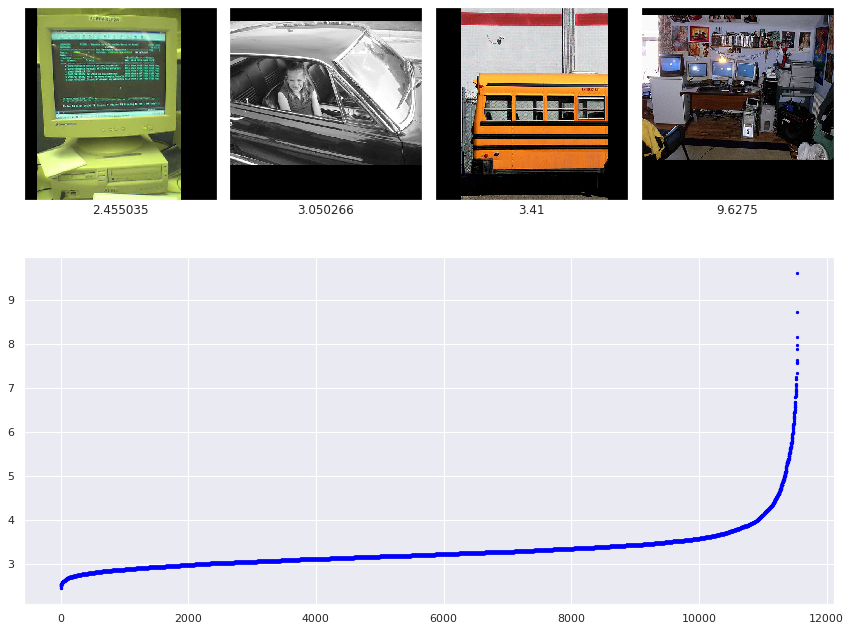

In [72]:
fig = plt.figure(constrained_layout=False, figsize=(12,10))
gs = fig.add_gridspec(2, 4)

img_ax = [fig.add_subplot(gs[0, ind]) for ind in range(4)]
scatter_ax = fig.add_subplot(gs[1:,:])

for ind, (name, img_dict) in enumerate(FOR_FIG.items()):
    img = img_dict['img']
    img = np.transpose(img, (1, 2, 0))
    img_ax[ind].set_xticks([])
    img_ax[ind].set_yticks([])
    img_ax[ind].imshow(img)
    img_ax[ind].set_xlabel(img_dict['vsd_score'])                 


scatter_kws={"color":"blue", "alpha":1, "s":5, "edgecolors":'face', "linewidths":1}

scatter_ax.scatter(x=np.arange(len(vsd_df)),
                   y=vsd_df['difficulty_score'].sort_values(),
                   **scatter_kws);

fig.tight_layout()